# Classification Trees and Random Forests

Project work for the course: Teoria degli Algoritmi.

Masters' Degree in Applied Mathematics, Sapienza University of Rome.

Exam date: July 5th 2021.

This project work provides a Python implementation for Classification Trees and Random Forests, a use-case example, an analysis of both run time and computational complexity of the algorithms. Throughout the presentation, a comparison with the implementation used by scikit-learn is made (accuracy and out of bag error rate)

In [1]:
import pandas as pd
import numpy as np
import random as rd
import math
import Time as t
from matplotlib import pyplot as plt
import node
import graphviz as gr
from sklearn import tree
import makeTest as mt
import buildtree as bn

# Building a classification tree on minimal datasets
Consider the following dataset:

In [2]:
c1 = [1,0,0,2,1,0,4]
c2 = [1,2,1,1,1,4,3]
c3 = [0,0,4,4,0,3,2]
c4 = [0,1,1,2,0,1,1]
d = {'col1':c1, 'col2':c2, 'col3':c3, 'col4':c4}
easyDataset = pd.DataFrame(d)
easyDataset = easyDataset.astype(float)

To build the classification tree we use the function buildTree(...) fixing some parameters:

- colName: name of the output column.
- featNum: number of features to be used to compute the splitting of the dataset. 
- dataDim: minimum number of row allowed to split the dataset. If this number is not reached, the whole dataset is used to built a tree leaf.
- tol: minumum impurity level (Gini impurity) required to split the dataset, otherwise the dataset produces a leaf.

Once built, the tree can be visualized using plotTree(...) importing the library
graphviz.

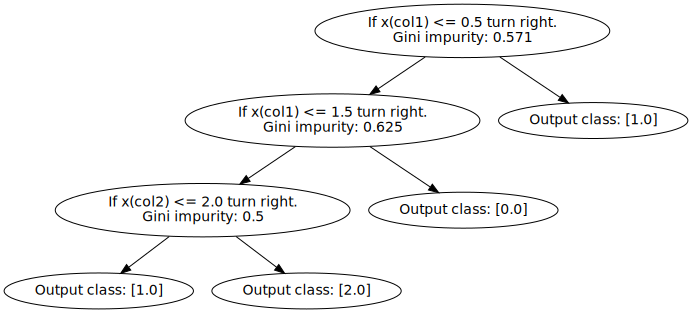

In [5]:
colName = 'col4'
tree1 = bn.buildTree(easyDataset, colName, featNum=4, dataDim=1, tol=0.0)
dot = gr.Digraph()
tree1.plotTree(dot)
dot

The inner nodes show:
- the feature selected to perform the splitting
- the related numerical value for which the splitting is realized.
- the Gini impurity level of the dataset befor the splitting is computed

The leaves contain the information regarding the output class in which the majority of final dataset points falls.

The code below shows the output tree computed by the scikit-learn implementation.

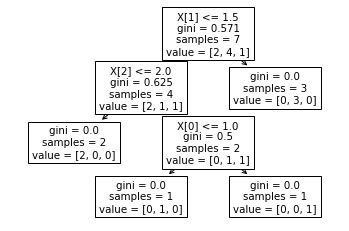

In [8]:
X = np.transpose(np.array([c1,c2,c3]))
Y = c4
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
tree.plot_tree(clf)
plt.show()

The same algorithms also works for datasets with non-numerical output colums

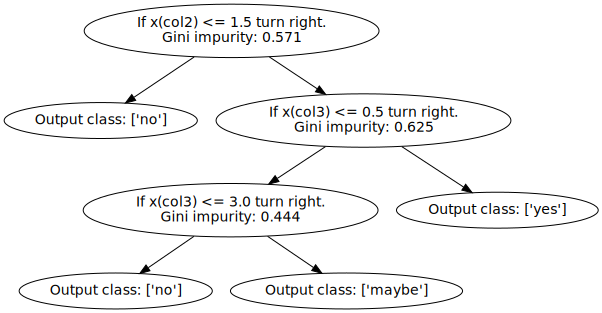

In [5]:
c1 = [1,2,1,2,1,0,4]
c2 = [1,2,1,1,1,4,2]
c3 = [0,1,4,2,1,3,1]
c4 = ['yes','no','no','maybe','maybe','no','no']
d = {'col1':c1, 'col2':c2, 'col3':c3, 'col4':c4}
easyDataset = pd.DataFrame(d)
easyDataset = easyDataset.iloc[:,0:3].astype(float)
easyDataset['col4'] = c4
tree2 = bn.buildTree(easyDataset, 'col4', featNum=4, dataDim=1, tol=0.0)

dot = gr.Digraph()
tree2.plotTree(dot)
dot

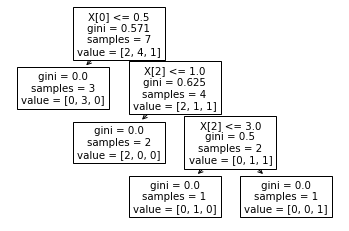

In [9]:
X = np.transpose(np.array([c1,c2,c3]))
Y = c4
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
tree.plot_tree(clf) 
plt.show()

## Computational complexity analysis
#### BuiltTree()

Put $ n =$ number of instances, $m =$ number of features, $K =$ number of output classes.

buildTree() has a complexity given by $T(n,m,K) = O(mn(logn+K)) + T(n_1,m,K) + T(n_2,m,K)$ , where $n_1 + n_2 = n$. 

If we consider $m,K$ as constants,  $T(n) = O(nlogn) + T(n_1) + T(n_2)$.

Best case:\
$T(n) \leq O(nlogn) + 2T(\frac{n}{2}) = O(nlogn) + 2O(\frac{n}{2}log(\frac{n}{2})) + 4T(\frac{n}{4})=...=O(n\displaystyle\sum_{k=1}^{logn}log(\frac{n}{2^k})) =  O(n(logn)^2 - nlog2\displaystyle\sum_{k=1}^{logn}k)= O(n(logn)^2)$ 


Worst case:\
$T(n) = O(nlogn) + T(n-1) = O(nlogn) + O((n-1)log(n-1)) + T(n-2) = ... = O(\displaystyle\sum_{k=1}^{n}klogk)$\
Notice that $\displaystyle\sum_{k=1}^{n}klogk = nlog(n!) - \displaystyle\sum_{k=1}^{n-1}klog(n-k) \leq  nlog(n!) \approx n(nlogn - n + O(logn)) = O(n^2logn)$\
Therefore:\
$T(n) = O(n^2logn)$

#### MakeForest()

Complexity: $O(nt) + tT(n,m,K)$  where t is the number of estimators

Consider K,m constant:

Worst case: $O(nt) + O(tn^2logn) = O(tn^2logn)$

Best case: $O(nt) + O((logn)^2) = O(tn(logn)^2)$

## Runtime Analysis

We want to have an idea, now,s of whether the previous algorithms actually have a runtime consistent with the computational complexity analysis.\
We randomly generate a dataset with dimensions 20000 x 9 and save it as a .csv file so that we can reuse it for further experiments.

In [2]:
Nmax = 20000
Nmin = 50
m = 9

columns = [f'col{i}' for i in range(m-1)]
d = {col: [rd.randint(1,10) for i in range(Nmax)] for col in columns}
data = pd.DataFrame(d)
data.to_csv(index=False,path_or_buf='speedDataset.csv')

In the next block we randomly genarate the output column as well. We will have to generate this column again each time we need to change the number of output classes while keeping the same input instances.

In [3]:
rMax = 2
path = 'speedDataset.csv'
data = pd.read_csv(path, sep=',')
data[f'col{m-1}'] = [rd.randint(1,rMax) for i in range(Nmax)] 

For each n from Nmin to Nmax consider a bootstrapped dataset with n rows extracted from the original one. For each bootstrapped dataset we compute the time (in seconds) needed to build a tree and save it in a list.

In [5]:
colName = f'col{m-1}'
dataDim = 1
tol = 0.0
featNum = m

st = 500
timeVect = np.array([])
xValues = [i for i in range(Nmin, Nmax, st)]

for n in xValues:
    r = np.random.randint(n,size=n)
    newData = data.iloc[r]
    t.tic()
    tree = bn.buildTree(newData, colName, featNum, dataDim, tol)
    timeCount = t.toc()
    timeVect = np.append(timeVect, timeCount)

We want to approximate the obtained data (i.e. the time vector). For each n in [Nmin,Nmax], compute
$$
r_n = \frac{\text{runtime of the dataset with n rows}}{n(logn)^2}
$$

Compute $a$ the average of the $\{r_n\}_n$ and plot both the time vector and the function $an(logn)^2%$.

In [8]:
import math

xValues = np.array(xValues)
coeffVect = np.array([])

for n in range(xValues.shape[0]):
    l = math.log(xValues[n])*xValues[n]*math.log(xValues[n])
    coeffVect = np.append(coeffVect,timeVect[n]/l)
a = np.mean(coeffVect)

logTempo = [a*n*math.log(n)*math.log(n) for n in range(Nmin,Nmax,st)]

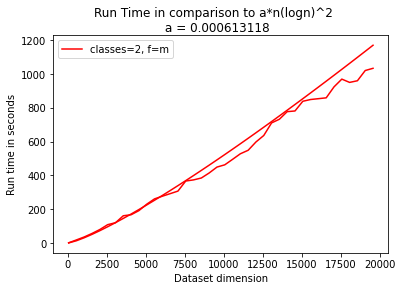

In [8]:
fig, ax = plt.subplots()
ax.plot(xValues,timeVect,'r',label='classes=2, f=m')
ax.plot(xValues,logTempo,'r')

plt.xlabel("Dataset dimension")
plt.ylabel("Run time in seconds")
ax.legend()
fig.suptitle(f'Run Time in comparison to a*n(logn)^2 \n a = {a}')
plt.show()

## Use-case: Wine dataset
This dataset contains the results of some tests made on about 1600 wines. The output column (named 'quality') reports a subjective evaluation made by wine experts with an integer value from 0 to 10.

In [9]:
path = 'winequality-red.csv'
wine = pd.read_csv(path, sep=';')
wine = wine.astype(float)

n = wine.shape[0]
m = wine.shape[1]

In [10]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0


We now apply the random forest algorithm through the function makeForest(..). The first parameter denotes the number of trees to be built, while the other parameters (colName, featNum, dataDim and tol) are the ones described above.

We want to analyze the trend of the out of bag error rate computed by the function makeForest(...) increasing the number of trees. 

First we set the hyperparameters featNum, dataDim and tol, than we generate many random forests, each with a different numeber of trees.

In [11]:
colName = 'quality'
dataDim = 1
featNum = 3
tol = 0.0

T = 101
minT = 10
step = 10

In [18]:
errVect = np.array([])
xValues = [t for t in range(minT,T,step)]

for t in xValues:
    forest,err = mt.makeForest(t,wine,colName,featNum,dataDim,tol)
    errVect = np.append(errVect,err)

We can compare the previous result with the OOB error rate computed by scikit-learn.
What is reported in their documentation is: 

"In contrast to the original publication [B2001], the scikit-learn mplementation combines classifiers bya veraging their probabilistic prediction,instead of letting each classifier vote for a single class."

The two OOB errors are computed differently, so we can expect some differences in the plot.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X = wine.iloc[:,0:10]
y = wine.iloc[:,11]

min_estimators = 2
max_estimators = 100
error_rate = np.array([])

clf = RandomForestClassifier(oob_score=True, max_features='sqrt',min_samples_split=2) 
for i in range(min_estimators, max_estimators+1):
    clf.set_params(n_estimators=i)
    clf.fit(X, y)
    oob_error = 1 - clf.oob_score_
    error_rate = np.append(error_rate, oob_error)

Both trends seem to stabilize: the one computed with makeForest already stabilizes with t = 10. The scikit learn OOB error rate stabilizes for higher values of t but at a lower level.

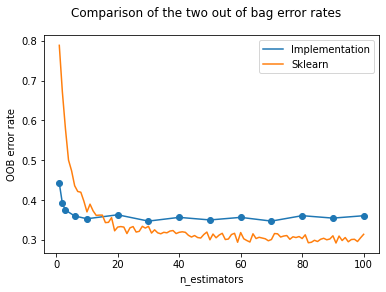

In [17]:
xAx = [i for i in range(min_estimators, max_estimators+1)]

fig1, ax = plt.subplots()
ax.plot(xValues,errVect,label='Implementation')
ax.scatter(xValues,errVect)
ax.plot(xAx,error_rate,label='Sklearn')
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend()
fig1.suptitle("Comparison of the two out of bag error rates")
plt.show()

## Accuracy test on the Wine dataset.
So far we could not really compare the two implementation on the base of the OOB error rate. We now try to build some random forests using as training set part of the wine dataset, leaving the rest as test set.
We compare the two implementation, than, evaluating the forecasting accuracy on the test set

The parameter $prop$ must be a real value in $(0,1)$ and represents the proportion of the training set on the original set.
The function makeTrainingSample(..) splits the inizial dataset according to this proportion.

Once we set the hyperparameter featNum, dataDim e tol, we are ready to build our random forests increasing the number of trees t.

The accuracy is so estimated:
for each point of the dataset compute the class voted from the majority of the trees. this class becomes the forecast made by the forest itself. Be $N$ the number of row in the test dataset and be $M$ the number of test instances for which the forest makes a wrong forecasting. The accuracy is calculated as $1 - \frac{M}{N}$

Below, we can see how the two implementations produce a similar accuracy plot.

In [32]:
prop = 0.7
xTrain,xTest = mt.makeTrainSample(wine,prop)

featNum=3
dataDim=1
tol=0.0
accTest = [1,2,3,5,7,10,15,20,30]

vect1 = np.array([])
for t in accTest:
    forest,err = mt.makeForest(t,xTrain,colName,featNum,dataDim,tol)
    acc = mt.accuracy(forest,xTest,colName)
    vect1 = np.append(vect1,acc)

In [18]:
prop = 0.7
xTrain,xTest = mt.makeTrainSample(wine,prop)

In [24]:
from sklearn.metrics import accuracy_score
vect2 = np.array([]) 

for t in accTest:
    clf = RandomForestClassifier(max_features='sqrt',n_estimators = t)
    clf.fit(xTrain.iloc[:,0:10], xTrain.iloc[:,11])
    prev = clf.predict(xTest.iloc[:,0:10])
    acc = accuracy_score(xTest.iloc[:,11], prev)
    vect2 = np.append(vect2,acc)

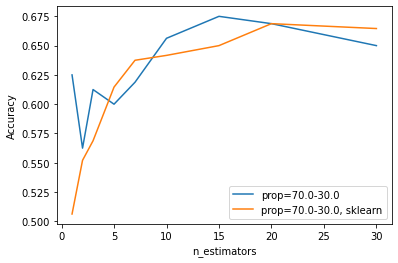

In [25]:
plt.plot(accTest,vect1,label=f'prop={100*prop}-{100-100*prop}')
plt.plot(accTest,vect2,label=f'prop={100*prop}-{100-100*prop}, sklearn')
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()